In [29]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1971 and all that
This notebook tries to explore Swiss newspaper articles from the [Impresso](https://impresso-project.ch/) corpus published between 1900 and 1971.

## Importing the required libraries

In [9]:
import nltk
#nltk.download("stopwords")
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import json
import glob
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy
import spacy
from nltk.corpus import stopwords

# visualizations
import pyLDAvis
import pyLDAvis.gensim_models
#from pyLDAvis import gensim

## Preparing the data
Get the newspaper articles as a list of strings

In [10]:
stopwords = stopwords.words("german")

### Loading the data

In [32]:
df_obj = pd.read_csv("data/frauenstimmrecht.csv", delimiter=';', encoding='utf-8')
# df_obj.head()

### Get the column with the article text

In [33]:
contents = df_obj["content"]
# name the single column
contents.columns = ['article_text',]
# contents.head()

### How many rows do we have?

In [15]:
# number of rows
contents.shape

(5798,)

### How many undefined values do we have?

In [16]:
# number of NA values (nulls) in column article_text
print('Number of nulls in article_text: {}'.format(df_obj['content'].isnull().sum()))

Number of nulls in article_text: 0


### Drop the undefined values

In [17]:
# drop NA (null) values
contents_noNull = contents.dropna()

### Write the article text strings in a list and print the number of articles

In [18]:
articles = [article for article in contents_noNull] 
print("Number of articles:", len(articles))

Number of articles: 5798


## Cleaning the data

In [21]:
# import spacy

def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "ADV"]):
    # import a trained model, language specific
    nlp = spacy.load("de_core_news_md", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

lemmatized_articles = lemmatization(articles)
print(lemmatized_articles[0][0:90])

Stimme Frauenstimmrecht Tat Tat Februar Februar Frauenstimmrecht % Professor Frauenstimmre


### Reduce the text to indivual words, remove stopwords
the function gen_words() returns a list containing lists of individual words.

In [34]:
def gen_words(texts):
    final = []
    for text in texts:
        # deacc=True means: accents are removed
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return final

data_words = gen_words(lemmatized_articles)

# print(data_words[0][:20])

### Bigrams and trigrams

In [24]:
# min_count: minimum of occurrences in order to qualify as a bigram
# threshold: number of phrases that are found (inversely - higher number means less phrases found) - to be played around with
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

# functions to recompute our data_words including bigrams and trigrams
def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[0][:20])

['stimme', 'tat', 'tat', 'februar', 'februar', 'professor', 'forderung', 'achtung_menschenwurde', 'folgerung', 'gleichstellung', 'schweizer', 'rechtsstaat', 'gesetz', 'unterworfen', 'burger', 'wesentlich', 'mitwirkung', 'erlaß_gesetz', 'darum', 'nationalrat']


### Remove frequently occurring words with TF-IDF
Create a dictionary with a mapping between single words/bigrams/trigrams and their numeric ID. Build a tuple per word, containing the word ID and their frequency in the article. Print the representation of the first twenty words of the first article. Print a particular word of the dictionary.

In [35]:
# may require some playing around with threshold - some important words may be filtered out
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print(corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]

    #reassign        
    corpus[i] = new_bow

### Preparing the data for the wordcloud
Create a dictionary with a string of article words per year.

In [19]:
# Initialize an empty dictionary - it will contain { year : "string containing all the lemmatized words from articles published in year"}
articlesPerYear = {}

# function returning a list of article words per year
def getWordsPerYear(year):
    df_obj_year = df_obj[df_obj["year"] == year]
    contents = df_obj_year["content"]
    # drop NA (null) values
    contents_noNull = contents.dropna()
    articles = [article for article in contents_noNull] 
    # print("Number of articles in", year, len(articles))
    # join all the articles in one string
    wordsPerYear = " ".join(articles)
    return wordsPerYear

for i in range(1900, 1981):
    articlesPerYear[i] = getWordsPerYear(i)

## Making the wordcloud
Create a wordcloud for a certain year.

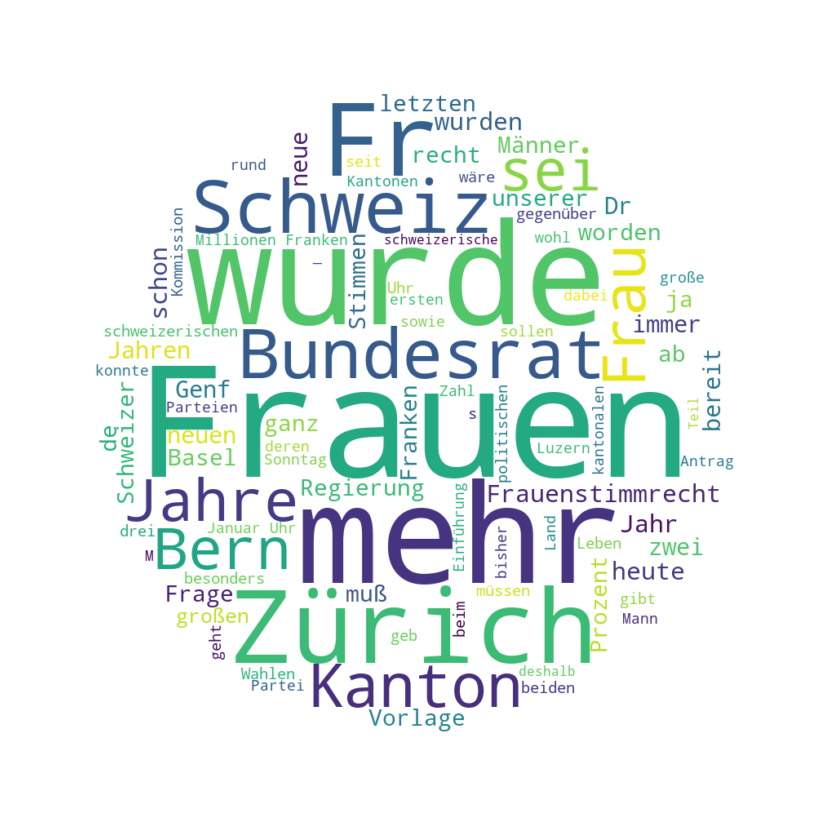

In [31]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
stops = stopwords.words("german")
STOPWORDS.update(stops)

def makeWordcloud(year):
    text = articlesPerYear[year]
    # Circle shape
    x, y = np.ogrid[:1000, :1000]

    mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
    mask = 255 * mask.astype(int)

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", max_words=90, mask=mask, relative_scaling=0.3).generate(text)
    # print(type(wordcloud))

    #cloudFigure = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#print(articlesPerYear[1979])
makeWordcloud(1961)

### Create the LDA topic model
Get topics out of the articles. 30 topics may be too many. Play with parameters.

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

## Visualizing the data

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis 

PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
8     -0.407616 -3.918358e-01       1        1  54.755072
28     0.085202 -5.232583e-01       2        1  27.662872
23    -0.379121  4.398581e-02       3        1   6.730582
6      0.185331 -1.523718e-01       4        1   1.600336
10     0.183476 -1.227445e-02       5        1   1.447502
2      0.156973  9.939334e-02       6        1   1.234445
17     0.069337  1.583914e-01       7        1   0.931571
11     0.037425 -7.571339e-02       8        1   0.893487
4     -0.079419  6.901744e-03       9        1   0.814531
13    -0.041843 -4.261445e-02      10        1   0.704981
12    -0.091770  9.215866e-02      11        1   0.647923
27    -0.024328  1.208952e-01      12        1   0.616843
21     0.050878 -7.329433e-07      13        1   0.479235
5     -0.000736 -1.818949e-02      14        1   0.402875
1      0.035386  6.699950e-02      15        1   0.282584
9      0.004405  7.531094e-02      16        1   0.236101
18     0.002803  4.909262e-02      17        1   0.146383
15     0.005630  3.665497e-02      18        1   0.130759
3      0.022747  3.307187e-02      19        1   0.085898
29     0.023634  4.094489e-02      20        1   0.078873
7      0.018395  4.133278e-02      21        1   0.043736
24     0.016153  3.940539e-02      22        1   0.017076
26     0.015350  3.908718e-02      23        1   0.014363
14     0.015948  3.913939e-02      24        1   0.012336
16     0.015960  3.891546e-02      25        1   0.005017
0      0.015960  3.891546e-02      26        1   0.004988
25     0.015960  3.891545e-02      27        1   0.004979
19     0.015960  3.891546e-02      28        1   0.004912
20     0.015960  3.891546e-02      29        1   0.004896
22     0.015960  3.891547e-02      30        1   0.004844, topic_info=                Term          Freq         Total Category  logprob  loglift
86                da  13107.000000  13107.000000  Default  30.0000  30.0000
3329              fr  12010.000000  12010.000000  Default  29.0000  29.0000
1543             uhr   3025.000000   3025.000000  Default  28.0000  28.0000
1770          kirche   5658.000000   5658.000000  Default  27.0000  27.0000
2841             mai  11369.000000  11369.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
24    gleichstellung      0.000231    108.369397  Topic30 -12.7997  -3.1226
25              gott      0.000231   1753.118879  Topic30 -12.7997  -5.9062
26              groß      0.000231  17269.551900  Topic30 -12.7997  -8.1938
27             grund      0.000231    422.112825  Topic30 -12.7997  -4.4823
29             heute      0.000231   1166.885268  Topic30 -12.7997  -5.4992

[1380 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4599      1  0.999968           abend
4266     12  0.980115        abermals
5088      5  0.996339         abnahme
5026      7  0.983996          absage
5027      7  0.971052     absichtlich
...     ...       ...             ...
4665      8  0.965831  zustandekommen
3189      4  0.994960        zutiefst
3385      7  0.991785     zuverlassig
2057     13  0.973348          zweier
4184      9  0.982637         zwingen

[504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 29, 24, 7, 11, 3, 18, 12, 5, 14, 13, 28, 22, 6, 2, 10, 19, 16, 4, 30, 8, 25, 27, 15, 17, 1, 26, 20, 21, 23])